# Advanced Artificial Intelligence William Forber 22015706:

### Imports and splitting features into different categories like numerical, categorical and redundant:

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

K = 5
test_results = []
k_fold = KFold(n_splits=K, shuffle=True, random_state=42)

dataset = pd.read_csv('../Dataset/Synthetic_Data_For_Students.csv')
dataset.head(10)
tf.config.list_physical_devices('GPU')

redundant_labels = ['AccidentType', 'Accident Description', 'Claim Date', 'Accident Date',
                    'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest',
                    'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications',
                    'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift',
                    'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy',
                    'Dominant injury']

category_labels = ['Exceptional_Circumstances', 'Minor_Psychological_Injury',
                   'Whiplash', 'Vehicle Type', 'Weather Conditions',
                   'Police Report Filed', 'Witness Present', 'Gender', 'Injury Description']

numerical_labels = ['SettlementValue', 'Injury_Prognosis',
                    'Vehicle Age', 'Driver Age', 'Number of Passengers']

### Functions for Pre-Processing Dataset - Removal of redundant features and null values, scaling and categorisation:

In [3]:
def clean_dataset(data):
    data.dropna(inplace=True)
    data.drop(redundant_labels, axis=1, inplace=True)
    return data


def categorise_data(data, label):
    values = data[label].astype(str).str.lower()

    if values.nunique() == 2 and set(values.unique()) <= {'yes', 'no'}:
        # Binary yes/no → boolean
        data[label] = values.map({'yes': True, 'no': False})

    elif values.nunique() <= 5:
        # Small number of categories → label encode
        data[label], _ = pd.factorize(data[label])

    else:
        # High cardinality → one-hot encode with prefix
        categories = pd.get_dummies(data[label], prefix=label)
        data.drop(label, axis=1, inplace=True)
        data = pd.concat([data, categories], axis=1)

    return data


def extract_months(prognosis):
    return int(''.join(filter(str.isdigit, prognosis)))


def scale_data(data):
    scaler = MinMaxScaler()
    data[numerical_labels] = scaler.fit_transform(data[numerical_labels])
    return data, scaler


def preprocess_data(data):
    data = clean_dataset(data)
    data['Injury_Prognosis'] = data['Injury_Prognosis'].apply(extract_months)
    upper_limit = data['SettlementValue'].quantile(0.95).max()
    lower_limit = data['SettlementValue'].quantile(0.05).min()
    data = data[data['SettlementValue'] <= upper_limit]
    data = data[data['SettlementValue'] >= lower_limit]
    data, scaler = scale_data(data)
    for label in category_labels:
        data = categorise_data(data, label)

    return data, scaler

### Defining the Control Model:

In [4]:
def base_model(X_train_tf):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(
            X_train_tf.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


### Defining the Tunable Model Based on the Control Model:

In [5]:
def build_model(hp, input_shape):
    model = keras.Sequential()

    # First layer activation handling
    activation_name = hp.Choice('activation_1', ['relu', 'tanh', 'leaky_relu'])
    activation = layers.LeakyReLU() if activation_name == 'leaky_relu' else activation_name

    # Input layer
    model.add(layers.Input(shape=(input_shape,)))

    model.add(layers.Dense(hp.Int('units_1', 32, 128, step=32),
                           activation=activation,
                           kernel_regularizer=tf.keras.regularizers.l2(
                               hp.Float('l2_reg_1', 1e-5, 1e-3, sampling='log'))))
    model.add(layers.Dropout(hp.Float('dropout_1', 0.0, 0.3)))

    if hp.Boolean('batch_norm_1'):
        model.add(layers.BatchNormalization())

    for i in range(0, hp.Int('num_layers', 0, 4, step=1)):
        model.add(layers.Dense(hp.Int('units_' + str(i + 2), 32, 128, step=32),
                               activation=activation,
                               kernel_regularizer=tf.keras.regularizers.l2(
                                   hp.Float('l2_reg_' + str(i + 2), 1e-5, 1e-3, sampling='log'))))
        model.add(layers.Dropout(hp.Float('dropout_' + str(i + 2), 0.0, 0.3)))

        if hp.Boolean('batch_norm_' + str(i + 2)):
            model.add(layers.BatchNormalization())

    model.add(layers.Dense(1, activation='softplus'))

    # Huber loss delta
    delta_value = hp.Float('huber_delta', 0.5, 5.0)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 0.0001, 0.01, sampling='log')),
        loss=tf.keras.losses.Huber(delta=delta_value),
        metrics=['mae']
    )

    return model

### Defining a function to evaluate the models using K-Fold-Cross-Validation:

In [6]:
def evaluate_model(model, X_test_tf, y_test_tf, scaler):
    y_pred_tf = model.predict(X_test_tf)
    y_pred_np = y_pred_tf.flatten()
    y_test_np = y_test_tf.numpy().flatten()

    # Get index of 'SettlementValue'
    settlement_value_index = numerical_labels.index('SettlementValue')

    # Calculate range
    min_val = scaler.data_min_[settlement_value_index]
    max_val = scaler.data_max_[settlement_value_index]
    range_val = max_val - min_val

    # Unscale
    y_pred_unscaled = y_pred_np * range_val + min_val
    y_test_unscaled = y_test_np * range_val + min_val

    test_mae = np.mean(np.abs(y_pred_unscaled - y_test_unscaled))
    test_r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    return test_mae, test_r2, y_test_unscaled, y_pred_unscaled


def cross_validate_model(model_builder, X_np, y_np, k_fold, scaler):
    fold_mae_scores = []
    fold_r2_scores = []
    actual_values = []
    predicted_values = []

    for fold_num, (train_index, test_index) in enumerate(k_fold.split(X_np), start=1):
        print(f"Processing fold {fold_num}/{k_fold.get_n_splits()}")
        X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
        y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

        X_train_tf = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
        X_test_tf = tf.convert_to_tensor(X_test_fold, dtype=tf.float32)
        y_train_tf = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
        y_test_tf = tf.convert_to_tensor(y_test_fold, dtype=tf.float32)

        model = model_builder(X_train_tf)

        early_stopping = EarlyStopping(
            monitor='val_mae',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        model.fit(
            X_train_tf, y_train_tf,
            epochs=50,
            batch_size=32,
            validation_data=(X_test_tf, y_test_tf),
            callbacks=[early_stopping]
        )

        fold_mae, fold_r2, y_actual, y_pred = evaluate_model(
            model, X_test_tf, y_test_tf, scaler)
        fold_mae_scores.append(fold_mae)
        fold_r2_scores.append(fold_r2)

        actual_values.extend(y_actual)
        predicted_values.extend(y_pred)

    average_mae = np.mean(fold_mae_scores)
    average_r2 = np.mean(fold_r2_scores)

    print(f'Average MAE across {k_fold.get_n_splits()} folds: {average_mae}')
    print(
        f'Average R² Score across {k_fold.get_n_splits()} folds: {average_r2}')

    return average_mae, average_r2, actual_values, predicted_values

### Defining the Function to Plot the Models Predicted Values against the Actual Values from the Testing Dataset:

In [7]:
def plot_predicted_vs_actual(y_actual, y_predicted, title="Predicted vs Actual Settlement Values"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.6)

    plt.plot([min(y_actual), max(y_actual)], [min(y_actual),
                                              max(y_actual)], color='red', linestyle='--')

    plt.xlabel("Actual Settlement Values")
    plt.ylabel("Predicted Settlement Values")
    plt.title(title)
    plt.show()

### Results From Pre-Processing the Dataset:

In [8]:
dataset, scaler = preprocess_data(dataset)
dataset.head(5)

,SettlementValue,Injury_Prognosis,Exceptional_Circumstances,Minor_Psychological_Injury,Whiplash,Vehicle Type,Weather Conditions,Vehicle Age,Driver Age,Number of Passengers,Injury Description,Police Report Filed,Witness Present,Gender
0,0.102564,0.285714,False,True,True,0,0,0.684211,0.245902,1.000000,0,True,True,0
1,0.240631,0.071429,False,True,True,0,1,0.210526,0.442623,0.333333,1,True,True,1
2,0.741617,0.428571,False,False,True,0,2,0.473684,0.442623,1.000000,0,True,False,1
3,0.102564,0.214286,False,True,True,1,0,0.263158,0.721311,0.000000,1,True,True,1
4,0.000000,0.142857,False,True,False,0,0,0.473684,0.983607,0.000000,2,True,True,2


### Settlement Value Histogram:

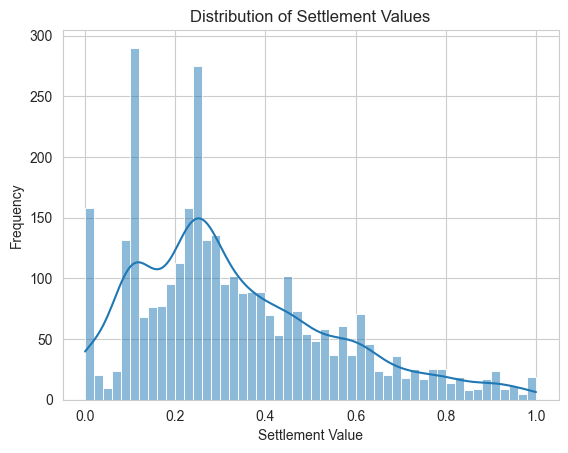

In [9]:
def settlement_value_histogram(data):
    sns.histplot(data['SettlementValue'], bins=50, kde=True)
    plt.title('Distribution of Settlement Values')
    plt.xlabel('Settlement Value')
    plt.ylabel('Frequency')
    plt.show()


settlement_value_histogram(dataset)

### Evaluating the Base Model:

In [10]:
X = dataset.drop('SettlementValue', axis=1)
y = dataset['SettlementValue']

X_np = X.values
y_np = y.values

print("Base model results: No hyperparameter tuning:")
base_mae, base_r2, base_actual, base_predicted = cross_validate_model(
    base_model, X_np, y_np, k_fold, scaler)

Base model results: No hyperparameter tuning:
Processing fold 1/5
Epoch 1/50


C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2606 - mae: 0.2606 - val_loss: 0.1579 - val_mae: 0.1579
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2044 - mae: 0.2044 - val_loss: 0.1532 - val_mae: 0.1532
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1801 - mae: 0.1801 - val_loss: 0.1513 - val_mae: 0.1513
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1648 - mae: 0.1648 - val_loss: 0.1480 - val_mae: 0.1480
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1577 - mae: 0.1577 - val_loss: 0.1475 - val_mae: 0.1475
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1460 - val_mae: 0.1460
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1549 - mae: 0.1549 - val_loss: 0.1481 - val_mae: 0.1481
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1444 - val_mae: 0.1444
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1475 - mae: 0.1475 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3398 - mae: 0.3398 - val_loss: 0.1742 - val_mae: 0.1742
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2350 - mae: 0.2350 - val_loss: 0.1609 - val_mae: 0.1609
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1974 - mae: 0.1974 - val_loss: 0.1596 - val_mae: 0.1596
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1740 - mae: 0.1740 - val_loss: 0.1528 - val_mae: 0.1528
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1652 - mae: 0.1652 - val_loss: 0.1505 - val_mae: 0.1505
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1657 - mae: 0.1657 - val_loss: 0.1524 - val_mae: 0.1524
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1541 - mae: 0.1541 - val_loss: 0.1518 - val_mae: 0.1518
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1491 - mae: 0.1491 - val_loss: 0.1503 - val_mae: 0.1503
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1533 - mae: 0.1533 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2897 - mae: 0.2897 - val_loss: 0.1667 - val_mae: 0.1667
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090 - mae: 0.2090 - val_loss: 0.1572 - val_mae: 0.1572
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1861 - mae: 0.1861 - val_loss: 0.1544 - val_mae: 0.1544
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1732 - mae: 0.1732 - val_loss: 0.1506 - val_mae: 0.1506
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1554 - mae: 0.1554 - val_loss: 0.1512 - val_mae: 0.1512
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1655 - mae: 0.1655 - val_loss: 0.1513 - val_mae: 0.1513
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1558 - mae: 0.1558 - val_loss: 0.1489 - val_mae: 0.1489
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1494 - mae: 0.1494 - val_loss: 0.1474 - val_mae: 0.1474
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1467 - mae: 0.1467 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2894 - mae: 0.2894 - val_loss: 0.1569 - val_mae: 0.1569
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2222 - mae: 0.2222 - val_loss: 0.1531 - val_mae: 0.1531
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1892 - mae: 0.1892 - val_loss: 0.1484 - val_mae: 0.1484
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1763 - mae: 0.1763 - val_loss: 0.1521 - val_mae: 0.1521
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1667 - mae: 0.1667 - val_loss: 0.1462 - val_mae: 0.1462
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1636 - mae: 0.1636 - val_loss: 0.1445 - val_mae: 0.1445
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1589 - mae: 0.1589 - val_loss: 0.1465 - val_mae: 0.1465
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1525 - mae: 0.1525 - val_loss: 0.1413 - val_mae: 0.1413
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1544 - mae: 0.1544 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3284 - mae: 0.3284 - val_loss: 0.1670 - val_mae: 0.1670
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2101 - mae: 0.2101 - val_loss: 0.1490 - val_mae: 0.1490
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1901 - mae: 0.1901 - val_loss: 0.1485 - val_mae: 0.1485
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1684 - mae: 0.1684 - val_loss: 0.1431 - val_mae: 0.1431
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1656 - mae: 0.1656 - val_loss: 0.1395 - val_mae: 0.1395
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 - mae: 0.1650 - val_loss: 0.1403 - val_mae: 0.1403
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.1403 - val_mae: 0.1403
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1578 - mae: 0.1578 - val_loss: 0.1403 - val_mae: 0.1403
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1507 - mae: 0.1507 - va

### Tuning the Hyper-Parameters:

In [11]:
tuner = kt.Hyperband(
    lambda hp: build_model(hp, X_np.shape[1]),
    objective='val_mae',
    max_epochs=100,
    factor=2,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='neural_network_hyper_parameters',
    seed=42
)

# Use a single train-test split for hyperparameter tuning
X_train_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)

early_stopping = EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True, verbose=1)

tuner.search(X_train_tf, y_train_tf, epochs=75, batch_size=32,
             validation_split=0.2, callbacks=[early_stopping])

best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]


def tuned_model_builder(X_train_tf):
    return build_model(best_hyper_parameters, X_train_tf.shape[1])


tuned_mae, tuned_r2, tuned_actual, tuned_predicted = cross_validate_model(
    tuned_model_builder, X_np, y_np, k_fold, scaler)


Trial 359 Complete [00h 00m 38s]
val_mae: 0.1442030370235443

Best val_mae So Far: 0.13996592909097672
Total elapsed time: 02h 04m 55s
Processing fold 1/5
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1314 - mae: 0.3224 - val_loss: 0.0528 - val_mae: 0.1740
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0588 - mae: 0.1946 - val_loss: 0.0481 - val_mae: 0.1757
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541 - mae: 0.1911 - val_loss: 0.0456 - val_mae: 0.1777
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - mae: 0.1855 - val_loss: 0.0416 - val_mae: 0.1738
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0453 - mae: 0.1779 - val_loss: 0.0376 - val_mae: 0.1590
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407 - mae: 0.1743 - val_loss: 0.0346 - val_mae: 0.1580
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - mae: 0.1661 - val_loss: 0.0325 - val_mae: 0.1497
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━

### Printing the Errors for the Tuned and Un-tuned models:

In [12]:
print("Average Mean Absolute Error for un-tuned model:", base_mae)
print("Average R² Score for un-tuned model:", base_r2)

print("Average Mean Absolute Error for tuned model:", tuned_mae)
print("Average R² Score for tuned model:", tuned_r2)

Average Mean Absolute Error for un-tuned model: 361.13733533917434
Average R² Score for un-tuned model: 0.1981199249660474
Average Mean Absolute Error for tuned model: 364.5105014907896
Average R² Score for tuned model: 0.22822606653300595


### Plotting the Predicted vs Actual Settlement Values for the Tuned and Un-tuned models:

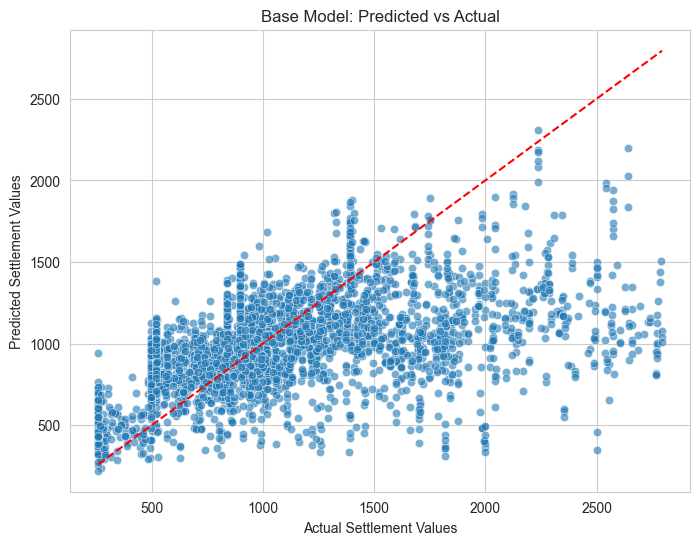

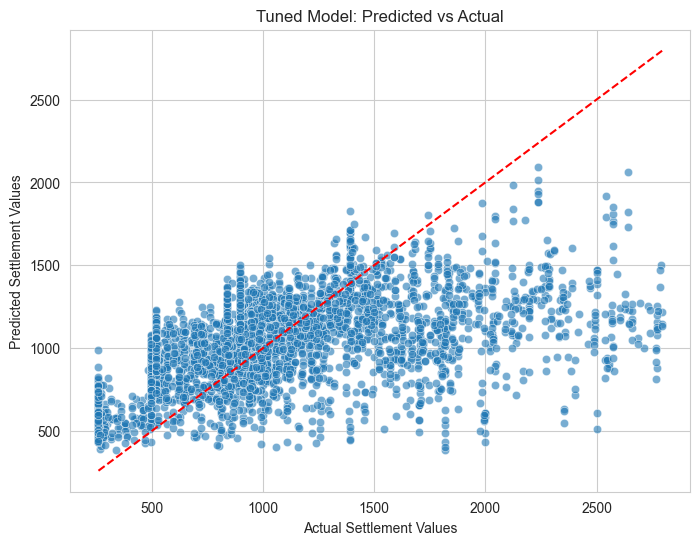

In [13]:
plot_predicted_vs_actual(base_actual, base_predicted,
                         "Base Model: Predicted vs Actual")
plot_predicted_vs_actual(tuned_actual, tuned_predicted,
                         "Tuned Model: Predicted vs Actual")